In [1]:
import AlphaVantage
import seaborn as sns

In [2]:
Key = 'Z0DPEH5EFNHR6W8D'
interval = 'monthly'

<Axes: xlabel='date', ylabel='value'>

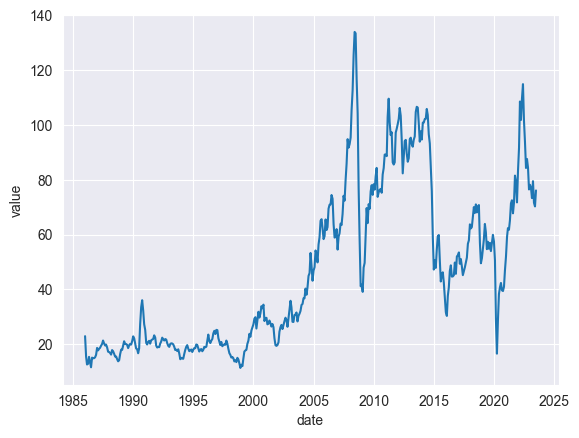

In [3]:
Oil_WTI = AlphaVantage.Commodity('WTI', interval,Key)
WTI_df = Oil_WTI.df
sns.lineplot(x=WTI_df['date'], y=WTI_df['value'], data=WTI_df)

<Axes: xlabel='date', ylabel='value'>

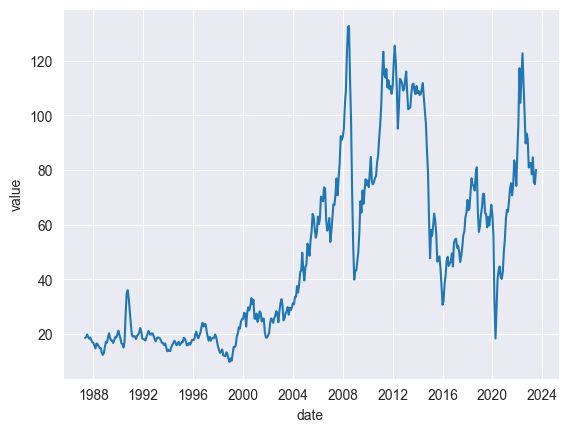

In [4]:
Oil_Brent = AlphaVantage.Commodity('BRENT', interval,Key)
Brent_df = Oil_Brent.df
sns.lineplot(x=Brent_df['date'], y=Brent_df['value'], data=Brent_df)

<Axes: xlabel='date', ylabel='value'>

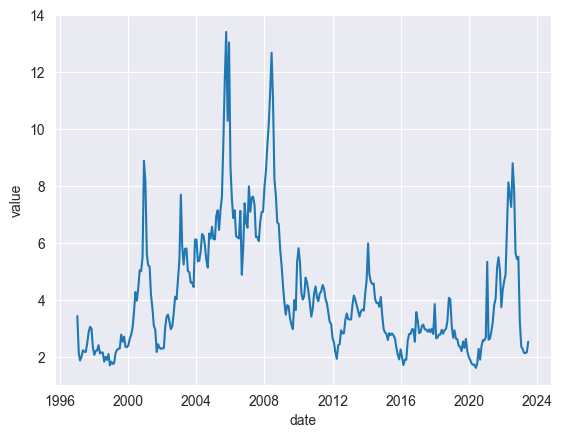

In [5]:
Gas = AlphaVantage.Commodity('NATURAL_GAS', interval,Key)
Gas_df = Gas.df
sns.lineplot(x=Gas_df['date'], y=Gas_df['value'], data=Gas_df)

<Axes: xlabel='date', ylabel='value'>

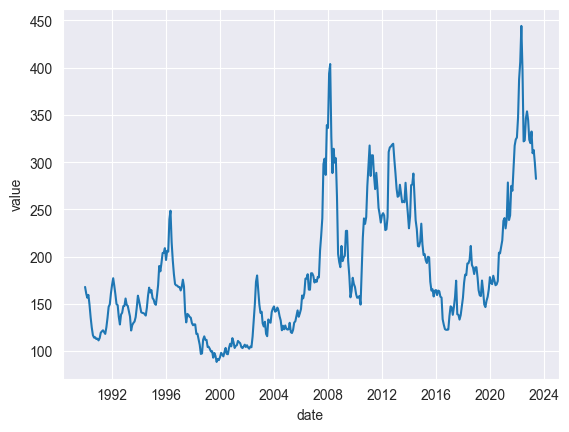

In [6]:
Wheat = AlphaVantage.Commodity('WHEAT', interval,Key)
Wheat_df = Wheat.df
sns.lineplot(x=Wheat_df['date'], y=Wheat_df['value'], data=Wheat_df)

Grouping by month to find seasonal pattern

<Axes: xlabel='month', ylabel='value'>

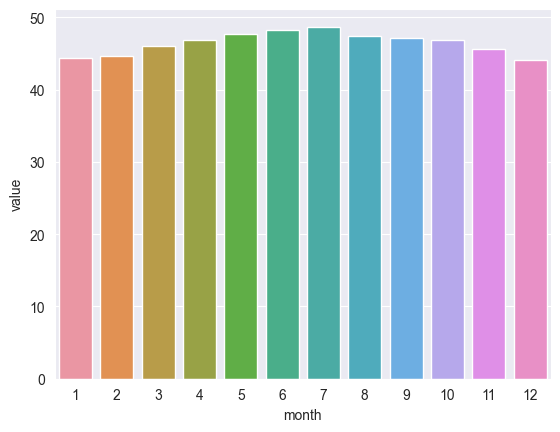

In [7]:
WTI_df['month'] = WTI_df['date'].dt.month
WTI_monthly_average = WTI_df.groupby('month', as_index=False)['value'].mean()
sns.barplot(x=WTI_monthly_average['month'], y=WTI_monthly_average['value'], data=WTI_monthly_average)

In [8]:
diff = (WTI_monthly_average['value'].max() - WTI_monthly_average['value'].min())/WTI_monthly_average['value'].max()*100
print(f'Difference is {diff} percents')

Difference is 9.32317216882977 percents


<Axes: xlabel='month', ylabel='value'>

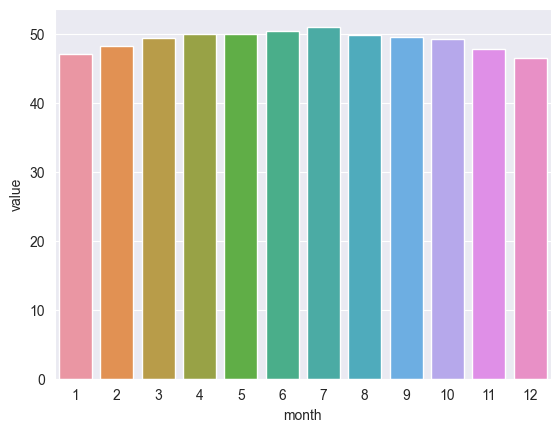

In [9]:
Brent_df['month'] = Brent_df['date'].dt.month
Brent_monthly_average = Brent_df.groupby('month', as_index=False)['value'].mean()
sns.barplot(x=Brent_monthly_average['month'], y=Brent_monthly_average['value'], data=Brent_monthly_average)

In [10]:
diff = (Brent_monthly_average['value'].max() - Brent_monthly_average['value'].min())/Brent_monthly_average['value'].max()*100
print(f'Difference is {diff} percents')

Difference is 8.816963103422706 percents


As we can see both oil prices have similar prices distribution, with highest prices at the middle of a year.

<Axes: xlabel='month', ylabel='value'>

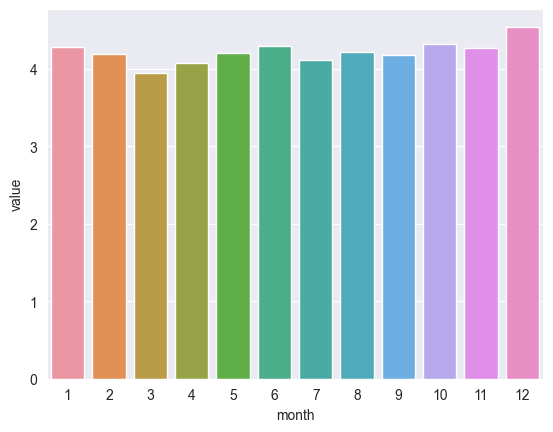

In [11]:
Gas_df['month'] = Gas_df['date'].dt.month
Gas_monthly_average = Gas_df.groupby('month', as_index=False)['value'].mean()
sns.barplot(x=Gas_monthly_average['month'], y=Gas_monthly_average['value'], data=Gas_monthly_average)

<Axes: xlabel='month', ylabel='value'>

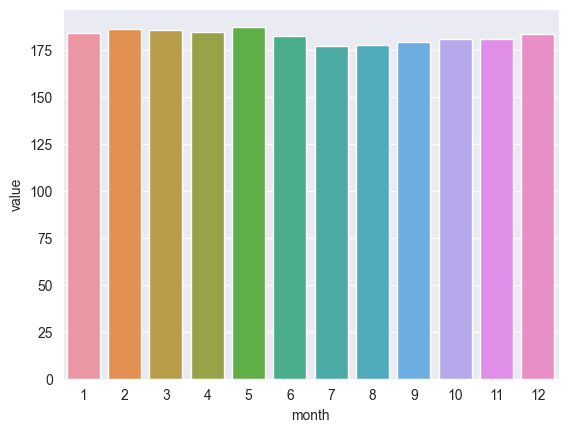

In [12]:
Wheat_df['month'] = Wheat_df['date'].dt.month
Wheat_monthly_average = Wheat_df.groupby('month', as_index=False)['value'].mean()
sns.barplot(x=Wheat_monthly_average['month'], y=Wheat_monthly_average['value'], data=Wheat_monthly_average)

Wheat prices seem to have no seasonal correlation at all

Plotting average oil companies stocks prices to find correlation with oil prices

In [13]:
Shell = AlphaVantage.Stock('SHEL', 'TIME_SERIES_MONTHLY', Key)
Shell_df = Shell.df
Shell_df

,time,open,high,low,close,volume
0,2023-08-28,61.22,63.095,59.505,61.42,79161247
1,2023-07-31,61.26,63.690,58.140,61.63,95060557
2,2023-06-30,56.18,61.170,56.030,60.38,103863077
3,2023-05-31,61.46,62.030,55.775,56.00,94998594
4,2023-04-28,60.75,62.310,59.010,61.98,78099258
...,...,...,...,...,...,...
280,2000-04-28,48.50,49.130,44.310,47.88,4622800
281,2000-03-31,41.31,49.630,40.310,49.06,7974800
282,2000-02-29,43.81,47.250,39.630,41.56,5640100
283,2000-01-31,49.75,51.130,42.880,43.88,5292400


<Axes: xlabel='month', ylabel='close'>

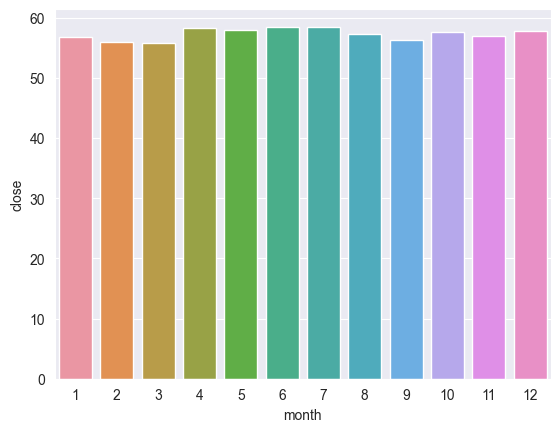

In [14]:
Shell_df['month'] = Shell_df['time'].dt.month
Shell_monthly_average = Shell_df.groupby('month', as_index=False)['close'].mean()
sns.barplot(x=Shell_monthly_average['month'], y=Shell_monthly_average['close'], data=Shell_monthly_average)

Two companies shows us, that there is no seasonal correlation

Prediction oil prices using XGBoost library

In [15]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Root Mean Squared Error: 2.355317028000353


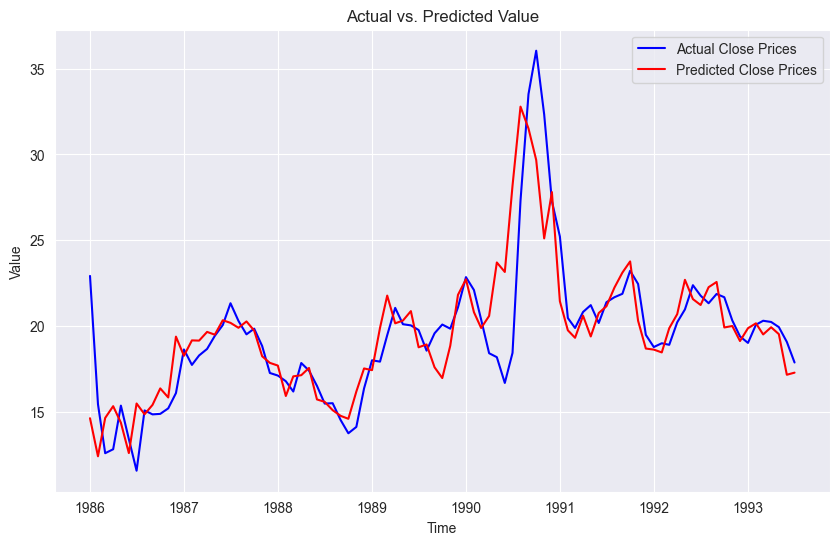

In [16]:
WTI_df.set_index('date', inplace=True)

num_lags = 12 # Using the previous week's data for forecasting
for i in range(1, num_lags + 1):
    WTI_df[f'lag_{i}_value'] = WTI_df['value'].shift(i)

train_size = int(0.8 * len(WTI_df))
train_data, test_data = WTI_df[:train_size], WTI_df[train_size:]

# Prepare the features and target variable
X_train, y_train = train_data.drop('value', axis=1), train_data['value']
X_test, y_test = test_data.drop('value', axis=1), test_data['value']

# Initialize the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

# Visualize actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test, label='Actual Close Prices', color='blue')
plt.plot(test_data.index, y_pred, label='Predicted Close Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Value')
plt.legend()
plt.show()

As we can see network can predict general pattern but not some huge changes